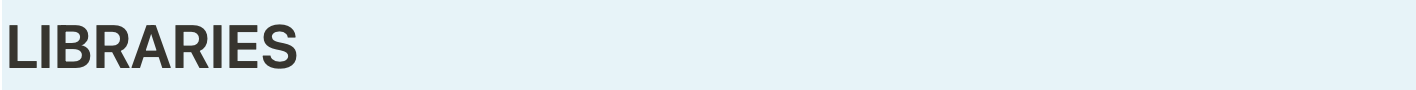

In [6]:
import os, re, glob, sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from scipy import ndimage
from skimage.transform import resize, rescale
from skimage.metrics import peak_signal_noise_ratio
from tensorflow.keras.preprocessing.image import img_to_array

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG19

from tensorflow.keras.layers import (
    Input, Dense, Conv2D, MaxPooling2D, MaxPool2D, Dropout, Activation,
    Conv2DTranspose, UpSampling2D, add, BatchNormalization,
    Concatenate, LeakyReLU
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras import layers as L
from tensorflow.keras.utils import plot_model
from keras.saving import register_keras_serializable

# Set random seed for reproducibility
np.random.seed(0)

# Check TensorFlow version
print(tf.__version__)


2.15.1


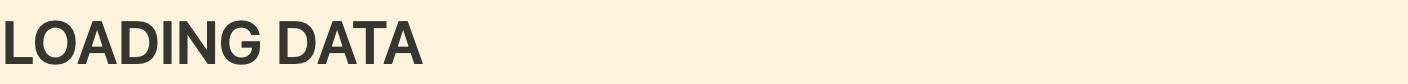

In [7]:


# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
path = '/Users/kunalnarwani/Desktop/Thesis/super-resolution/dataset/Raw Data/high_res' 
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.png':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))


low_img = []
path = '/Users/kunalnarwani/Desktop/Thesis/super-resolution/dataset/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == '855.png':
        break
    else: 
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:810]
validation_low_image = low_img[700:810]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[810:]
test_low_image = low_img[810:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)


100%|██████████| 855/855 [00:01<00:00, 495.65it/s]


Shape of training images: (700, 256, 256, 3)
Shape of test images: (45, 256, 256, 3)
Shape of validation images: (110, 256, 256, 3)


# ARCITECTURE OF MODEL 


In [32]:
import math
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras import Model, Input
from tensorflow.keras.saving import register_keras_serializable

# ---------- Resize layers ----------
@register_keras_serializable(package="resize")
class ResizeByScale(L.Layer):
    def __init__(self, scale, method="bilinear", antialias=True, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.scale = float(scale); self.method = method; self.antialias = antialias
    def call(self, x):
        x_dtype = x.dtype
        h = tf.shape(x)[1]; w = tf.shape(x)[2]
        nh = tf.cast(tf.round(tf.cast(h, tf.float32) * self.scale), tf.int32)
        nw = tf.cast(tf.round(tf.cast(w, tf.float32) * self.scale), tf.int32)
        y = tf.image.resize(tf.cast(x, tf.float32), [nh, nw], method=self.method, antialias=self.antialias)
        return tf.cast(y, x_dtype)
    def get_config(self):
        return {**super().get_config(), "scale": self.scale, "method": self.method, "antialias": self.antialias}

@register_keras_serializable(package="resize")
class ResizeToMatch(L.Layer):
    def __init__(self, method="bilinear", antialias=True, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.method = method; self.antialias = antialias
    def call(self, inputs):
        x, ref = inputs
        target = tf.shape(ref)[1:3]
        y = tf.image.resize(tf.cast(x, tf.float32), target, method=self.method, antialias=self.antialias)
        return tf.cast(y, x.dtype)
    def get_config(self):
        return {**super().get_config(), "method": self.method, "antialias": self.antialias}

# ---------- Core ----------
def conv_block(inputs, nf):
    x = L.Conv2D(nf, 3, padding="same", use_bias=True)(inputs)
    x = L.LayerNormalization(axis=-1)(x); x = L.Activation("relu")(x)
    x = L.Conv2D(nf, 3, padding="same", use_bias=True)(x)
    x = L.LayerNormalization(axis=-1)(x); x = L.Activation("relu")(x)
    return x

@register_keras_serializable(package="utils")
class ClipAdd(L.Layer):
    def call(self, inputs):
        inp, r = inputs
        y = tf.cast(inp, tf.float32) + tf.cast(r, tf.float32)
        return tf.cast(tf.clip_by_value(y, 0.0, 1.0), inp.dtype)

# ---------- Depth rule: per_level_down == scale ----------
HR = 256
MIN_BOTTLENECK = 16

def max_levels_equal(scale: float, hr: int = HR, min_bottleneck: int = MIN_BOTTLENECK, L_cap: int = 5) -> int:
    """Levels when every downsample uses the SAME scale factor (per_level_down==scale), with safety cap."""
    h = hr
    L_levels = 0
    while int(math.floor(h * scale)) >= min_bottleneck and L_levels < L_cap:
        h = int(math.floor(h * scale))
        L_levels += 1
    return max(L_levels, 1)

# ---------- Encoder/Decoder blocks using 'scale' per level ----------
def encoder_block(inputs, nf, down_layer):
    x = conv_block(inputs, nf)
    p = down_layer(x)          # shrink by 'scale'
    return x, p

def decoder_block(inputs, skip_features, nf, up_layer):
    x = up_layer([inputs, skip_features])   # upsize to skip size
    x = L.Conv2D(nf, 3, padding='same', activation='relu')(x)
    x = L.Concatenate()([x, skip_features])
    x = conv_block(x, nf)
    return x

# ---------- Builder (per_level_down == scale) ----------
def build_super_resolution_unet(scale: float,
                                     base_channels: int = 64,
                                     residual_head_channels: int = 64,
                                     L_cap: int = 5):
    assert 0.1 <= scale <= 0.99, "Use 0<scale<1; near-1 requires a small L_cap."
    L_levels = max_levels_equal(scale, hr=HR, min_bottleneck=MIN_BOTTLENECK, L_cap=L_cap)

    down = ResizeByScale(scale,  name="enc_down")
    up_to = ResizeToMatch(name="dec_up")

    inputs = Input(shape=(HR, HR, 3))
    skips = []
    x = inputs

    # Encoder
    nf = base_channels
    for _ in range(L_levels):
        s, x = encoder_block(x, nf, down_layer=down)
        skips.append(s)
        nf *= 2

    # Bottleneck
    x = conv_block(x, nf)

    # Decoder
    for s in reversed(skips):
        nf //= 2
        x = decoder_block(x, s, nf, up_layer=up_to)

    # Residual head (zero-init for identity start)
    xh  = conv_block(x, residual_head_channels)
    res = L.Conv2D(3, 1, padding="same", kernel_initializer="zeros", bias_initializer="zeros", name="residual_rgb")(xh)
    out = ClipAdd(name="enhanced_rgb")([inputs, res])

    model = Model(inputs, out, name=f"U-Net_SR_tied_s{scale:.2f}_L{L_levels}_cap{L_cap}")
    info = {"scale": scale, "levels": L_levels, "L_cap": L_cap}
    return model, info

# ======================= Quick sanity check =======================

if __name__ == "__main__":
    tf.keras.backend.clear_session()
    model, info = build_super_resolution_unet(scale=0.5, base_channels=64, L_cap=6)
    print(info)
    print("Sanity out:", y.shape)
    model.summary()

{'scale': 0.5, 'levels': 4, 'L_cap': 6}
Sanity out: (1, 256, 256, 3)
Model: "U-Net_SR_tied_s0.50_L4_cap6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 layer_normalization (Layer  (None, 256, 256, 64)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 ac

In [26]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

vgg = VGG19(include_top=False, weights="imagenet", input_shape=(256, 256, 3))
vgg.trainable = False
feat_extractor = tf.keras.Model(
    inputs=vgg.input,
    outputs=vgg.get_layer("block4_conv4").output,
)

alpha = tf.constant(1.0,  dtype=tf.float32)
beta  = tf.constant(0.1,  dtype=tf.float32)
gamma = tf.constant(0.01, dtype=tf.float32)

def mse_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    val = tf.reduce_mean(tf.square(y_true - y_pred))
    return tf.cast(val, tf.float32)

def ssim_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    val = 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return tf.cast(val, tf.float32)

def perceptual_loss(y_true, y_pred):
    y_true = tf.cast(tf.clip_by_value(y_true, 0.0, 1.0), tf.float32)
    y_pred = tf.cast(tf.clip_by_value(y_pred, 0.0, 1.0), tf.float32)
    feat_true = feat_extractor(preprocess_input(y_true * 255.0))
    feat_pred = feat_extractor(preprocess_input(y_pred * 255.0))
    val = tf.reduce_mean(tf.square(feat_true - feat_pred))
    return tf.cast(val, tf.float32)

def combined_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    total = (
        alpha * mse_loss(y_true, y_pred)
        + beta  * ssim_loss(y_true, y_pred)
        + gamma * perceptual_loss(y_true, y_pred)
    )
    return tf.cast(total, tf.float32)

def psnr_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.clip_by_value(y_pred, 0.0, 1.0), tf.float32)
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))

In [27]:
# ============================== Optimizer / compile ========================= #
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# ===== Compile =====
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=[psnr_metric],
)

print("python exec:", sys.executable)
print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

python exec: /Users/kunalnarwani/Desktop/Thesis/super-resolution/.venv/bin/python
TF version: 2.15.1
GPUs: []


In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, BackupAndRestore

BATCH_SIZE = 4
EPOCHS = 100
SEED = 42  # optional, keeps shuffle deterministic across restarts

train_ds = (
    tf.data.Dataset.from_tensor_slices((train_low_image, train_high_image))
      .shuffle(len(train_low_image), seed=SEED, reshuffle_each_iteration=True)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)

valid_ds = (
    tf.data.Dataset.from_tensor_slices((validation_low_image, validation_high_image))
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)

MODEL_DIR = "/Users/kunalnarwani/Desktop/Thesis/super-resolution/models"
os.makedirs(MODEL_DIR, exist_ok=True)

early_stop = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

model_ckpt = ModelCheckpoint(
    filepath=os.path.join(MODEL_DIR, "best_by_val_loss_0.6.keras"),
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1,
)

backup_cb = BackupAndRestore(os.path.join(MODEL_DIR, "train_backup"))

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[early_stop, model_ckpt, backup_cb],
    verbose=2,
)


Epoch 1/100

Epoch 1: val_loss did not improve from inf
175/175 - 565s - loss: nan - psnr_metric: 29.8278 - val_loss: nan - val_psnr_metric: 30.1294 - 565s/epoch - 3s/step
Epoch 2/100


KeyboardInterrupt: 

In [ ]:
EVAL_BATCH = 8  # adjust for GPU/CPU memory
eval_ds = (
    tf.data.Dataset.from_tensor_slices((validation_low_image, validation_high_image))
      .batch(EVAL_BATCH)
      .prefetch(tf.data.AUTOTUNE)
)

all_psnr, all_ssim, all_msssim = [], [], []
n_images = 0

for lr_b, hr_b in eval_ds:
    pred_b = model(lr_b, training=False)

    if pred_b.shape[1:3] != hr_b.shape[1:3]:  # still guards future changes
        pred_b = tf.image.resize(pred_b, size=hr_b.shape[1:3], method="bicubic")

    hr_tf   = tf.cast(hr_b, tf.float32)
    pred_tf = tf.cast(tf.clip_by_value(pred_b, 0.0, 1.0), tf.float32)

    all_psnr.append(tf.image.psnr(hr_tf, pred_tf, max_val=1.0).numpy())
    all_ssim.append(tf.image.ssim(hr_tf, pred_tf, max_val=1.0).numpy())
    all_msssim.append(tf.image.ssim_multiscale(hr_tf, pred_tf, max_val=1.0).numpy())

    n_images += int(hr_b.shape[0])

def mean_std(x):
    x = np.concatenate(x, axis=0).astype(np.float64)
    return float(np.mean(x)), float(np.std(x))

m_psnr, s_psnr   = mean_std(all_psnr)
m_ssim, s_ssim   = mean_std(all_ssim)
m_msssim, s_msssim = mean_std(all_msssim)

print(f"Validation images evaluated: {n_images}")
print(f" PSNR    : {m_psnr:.4f} ± {s_psnr:.4f} dB")
print(f" SSIM    : {m_ssim:.4f} ± {s_ssim:.4f}")
print(f" MS-SSIM : {m_msssim:.4f} ± {s_msssim:.4f}")


Validation images evaluated: 110
 PSNR    : 31.1567 ± 3.5405 dB
 SSIM    : 0.9250 ± 0.0430
 MS-SSIM : 0.9939 ± 0.0040


2025-09-23 13:03:31.641486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
